# Calling Glass Defect CV model

<img src="https://raw.githubusercontent.com/retkowsky/InstanceSegmentation/main/captures/example.jpg?">

In [1]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import datetime
import matplotlib.pyplot as plt 
import uuid
from IPython.display import display_javascript, display_html, display
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import os
import cv2

In [2]:
import sys
sys.version

'3.8.1 (default, Jan  8 2020, 22:29:32) \n[GCC 7.3.0]'

In [3]:
now = datetime.datetime.now()
print("Today:", now)

Today: 2022-01-04 10:04:57.879587


In [4]:
import azureml.core
print("Azure ML version:", azureml.core.VERSION)

Azure ML version: 1.34.0


## 1. Azure ML workspace

In [5]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


## 2. Defining a class object to display the JSON model results

In [6]:
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

## 3. Let's use the deployed model we made

In [7]:
service = Webservice(workspace=ws, name='automl-instanceseg-glass')

In [8]:
#print(service.scoring_uri)
#print(service.swagger_uri)

In [9]:
primary, secondary = service.get_keys()

In [10]:
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

## 4. Settings

In [11]:
round_values = 4
color_dots = 'orange'
color_back = 'red'
color_rect = 'lime'
color_text = 'lime'
rect_line_width = 5
marker_size = 10
font_size = 22
txtoffset = 15

In [12]:
IMAGE_SIZE = (15, 12)

In [13]:
min_confscore = 0.7

## 4.1 Example 1

In [14]:
test_image = "test/defect1.png"

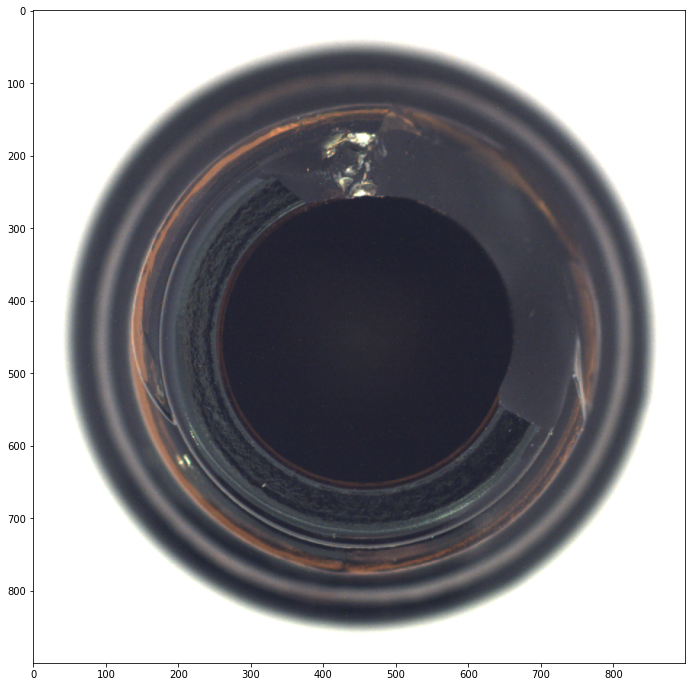

In [15]:
img = cv2.imread(test_image)
plt.figure(figsize=IMAGE_SIZE) 
#plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## Calling the model

In [16]:
t1 = datetime.datetime.now()

data = open(test_image, "rb").read()
headers = {"Content-Type": "application/octet-stream"}
headers["Authorization"] = f"Bearer {key}"
resp = requests.post(scoring_uri, data, headers=headers)

t2 = datetime.datetime.now()
print("Elapsed time:", t2 - t1)

Elapsed time: 0:00:02.527956


## Json results

In [17]:
RenderJSON(resp.text)

In [18]:
detections = json.loads(resp.text)

nlabel = 1
for detect in detections["boxes"]:
    if detect["score"] > min_confscore: # Min Value
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]
        print("\033[1;31;34m", nlabel, label, 'with confidence =', conf_score)
        print("\nPolygon:", polygon, '\n')
        nlabel+=1

if (nlabel-1) != 0:
    print("\n\033[1;31;91m[Alert]:", nlabel-1, "defect(s) has been detected.")

if (nlabel-1) == 0:
    print("\n\033[1;31;34m[OK]: No Quality Control issue has been detected!")

 1 defect with confidence = 0.9790133237838745

Polygon: [[0.775, 0.6183333333333333, 0.7383333333333333, 0.61, 0.73, 0.6016666666666667, 0.7266666666666667, 0.595, 0.7183333333333334, 0.57, 0.7216666666666667, 0.51, 0.725, 0.49833333333333335, 0.7216666666666667, 0.475, 0.725, 0.46, 0.7166666666666667, 0.44333333333333336, 0.715, 0.42333333333333334, 0.7066666666666667, 0.4066666666666667, 0.6983333333333334, 0.3983333333333333, 0.6916666666666667, 0.38333333333333336, 0.6533333333333333, 0.3466666666666667, 0.6183333333333333, 0.325, 0.605, 0.31333333333333335, 0.5916666666666667, 0.30833333333333335, 0.58, 0.30833333333333335, 0.5633333333333334, 0.30333333333333334, 0.5333333333333333, 0.3016666666666667, 0.49333333333333335, 0.3016666666666667, 0.48, 0.305, 0.44, 0.30666666666666664, 0.4116666666666667, 0.3, 0.4, 0.2866666666666667, 0.39, 0.2683333333333333, 0.37, 0.245, 0.37, 0.24, 0.37833333333333335, 0.225, 0.38666666666666666, 0.21833333333333332, 0.4066666666666667, 0.2133333

## Results

Instance Segmentation custom vision model predictions:

 1 	glass Defect(s) detected: defect with confidence = 0.979 	in region: 312.0698 162.9407 438.1071 455.6842

 >> Total of detected glass defect(s) = 1


<Figure size 1080x864 with 0 Axes>

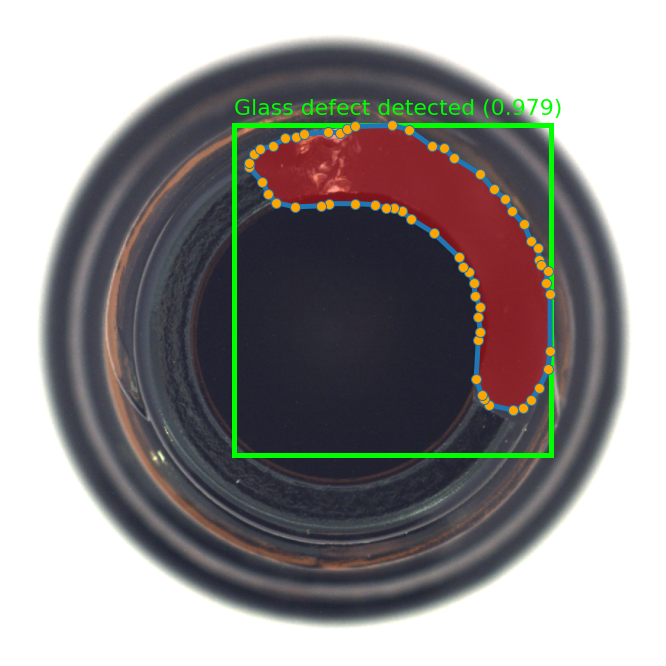

In [19]:
%matplotlib inline
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image

plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(test_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=IMAGE_SIZE) # Dimensions
ax.imshow(img_np)

totalobjects = 0
numberobjects = 1

print("Instance Segmentation custom vision model predictions:\n")

detections = json.loads(resp.text)

for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    polygon = detect["polygon"]
    conf_score = detect["score"]
    
    if conf_score > min_confscore:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        print("\033[1;31;34m", numberobjects, '\tglass Defect(s) detected:', detect["label"], "with confidence =", 
              round(conf_score, round_values),
              "\tin region:", round(topleft_x, round_values), round(topleft_y, round_values), round(width, round_values),
              round(height, round_values))
        
        numberobjects+=1
        
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=rect_line_width,
            edgecolor=color_rect,
            facecolor="none",
        )

        ax.add_patch(rect)
        labeltxt = 'Glass ' + label + ' detected'
        labelmsg = labeltxt + ' (' + str(round(conf_score, round_values)) + ')'
        plt.text(topleft_x, topleft_y - txtoffset, labelmsg, color=color_text, fontsize=font_size)

        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=color_back, alpha=0.4)
        ax.add_patch(poly)
        
        poly_line = Line2D(
            polygon_np[:, 0],
            polygon_np[:, 1],
            linewidth=5,
            marker="o",
            markersize=marker_size,
            markerfacecolor=color_dots,
        )
        ax.add_line(poly_line)
 
    totalobjects = numberobjects - 1
    
    regiontopleftx = int(topleft_x) 
    regiontoplefty = int(topleft_y)
    regionw = int(width)
    regionh = int(height)
    imgtocrop = cv2.imread(test_image)
    cropped_image = imgtocrop[regiontoplefty:regiontoplefty+regionh, regiontopleftx:regiontopleftx+regionw]
    image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    pathname, extension = os.path.splitext(test_image)
    pathname2 = pathname + '_' + str(totalobjects) + '_ROI' + extension
    cv2.imwrite(pathname2,image_rgb)
    


outputfilename = os.path.splitext(test_image)[0] + '_has_' + str(totalobjects) + '_defects.jpg'
fig.savefig(outputfilename, dpi=150) #Saving image

print("\n \033[1;31;91m>> Total of detected glass defect(s) =", totalobjects)
plt.axis('off')
plt.show()

## Extraction of the ROI

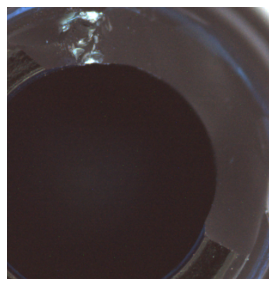

In [20]:
img = cv2.imread("test/defect1_1_ROI.png")
plt.figure(figsize=(5,5)) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## 4.2 Example 2

In [21]:
test_image = "test/defect2.png"

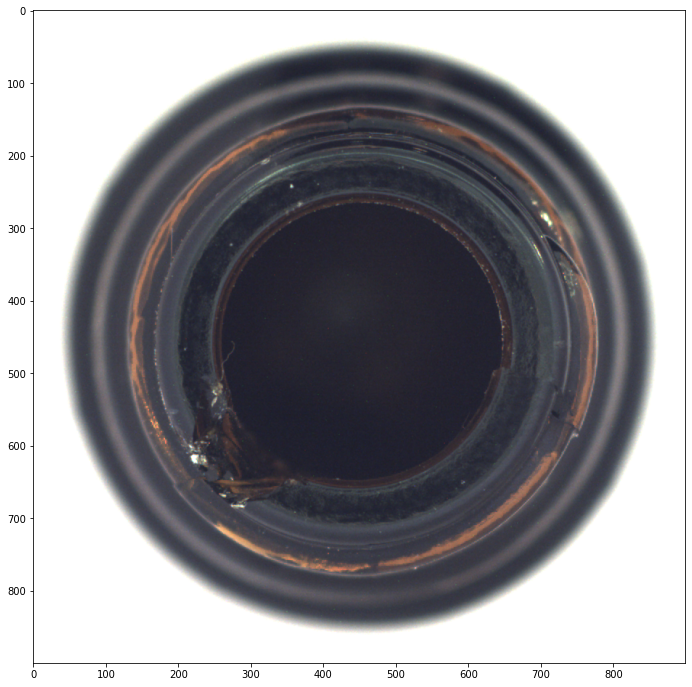

In [22]:
img = cv2.imread(test_image)
plt.figure(figsize=IMAGE_SIZE) 
#plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [23]:
t1 = datetime.datetime.now()

data = open(test_image, "rb").read()
headers = {"Content-Type": "application/octet-stream"}
headers["Authorization"] = f"Bearer {key}"
resp = requests.post(scoring_uri, data, headers=headers)

t2 = datetime.datetime.now()
print("Elapsed time:", t2 - t1)

Elapsed time: 0:00:02.379418


In [24]:
RenderJSON(resp.text)

In [25]:
detections = json.loads(resp.text)

nlabel = 1
for detect in detections["boxes"]:
    if detect["score"] > min_confscore: # Min Value
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]
        print("\033[1;31;34m", nlabel, label, 'with confidence =', conf_score)
        print("\nPolygon:", polygon, '\n')
        nlabel+=1

if (nlabel-1) != 0:
    print("\n\033[1;31;91m[Alert]:", nlabel-1, "defect(s) has been detected.")

if (nlabel-1) == 0:
    print("\n\033[1;31;34m[OK]: No Quality Control issue has been detected!")

 1 defect with confidence = 0.7957237958908081

Polygon: [[0.31833333333333336, 0.755, 0.30333333333333334, 0.7516666666666667, 0.27666666666666667, 0.7333333333333333, 0.2683333333333333, 0.7233333333333334, 0.26666666666666666, 0.7166666666666667, 0.25333333333333335, 0.7, 0.24333333333333335, 0.6783333333333333, 0.24, 0.655, 0.24166666666666667, 0.63, 0.235, 0.5966666666666667, 0.235, 0.585, 0.23666666666666666, 0.58, 0.25333333333333335, 0.5633333333333334, 0.2683333333333333, 0.555, 0.2833333333333333, 0.555, 0.295, 0.5616666666666666, 0.30333333333333334, 0.575, 0.30333333333333334, 0.58, 0.30833333333333335, 0.5866666666666667, 0.31, 0.5966666666666667, 0.31666666666666665, 0.605, 0.31833333333333336, 0.6133333333333333, 0.3566666666666667, 0.6516666666666666, 0.365, 0.6633333333333333, 0.36833333333333335, 0.6733333333333333, 0.375, 0.6783333333333333, 0.38, 0.6916666666666667, 0.38166666666666665, 0.71, 0.37833333333333335, 0.7133333333333334, 0.375, 0.725, 0.37, 0.72666666666

Instance Segmentation custom vision model predictions:

 1 	glass Defect(s) detected: defect with confidence = 0.7957 	in region: 209.3912 491.4215 144.0795 190.9517

 >> Total of detected glass defect(s) = 1


<Figure size 1080x864 with 0 Axes>

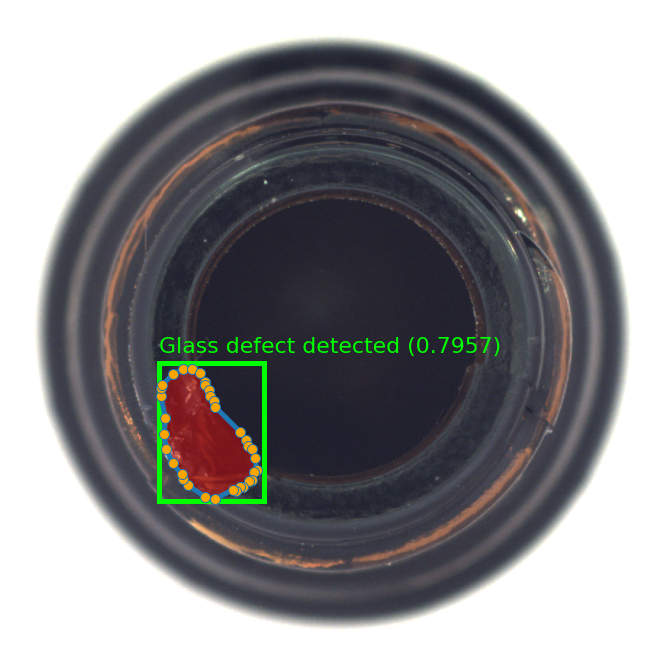

In [26]:
%matplotlib inline
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image

plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(test_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=IMAGE_SIZE) # Dimensions
ax.imshow(img_np)

totalobjects = 0
numberobjects = 1

print("Instance Segmentation custom vision model predictions:\n")

detections = json.loads(resp.text)

for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    polygon = detect["polygon"]
    conf_score = detect["score"]
    
    if conf_score > min_confscore:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        print("\033[1;31;34m", numberobjects, '\tglass Defect(s) detected:', detect["label"], "with confidence =", 
              round(conf_score, round_values),
              "\tin region:", round(topleft_x, round_values), round(topleft_y, round_values), round(width, round_values),
              round(height, round_values))
        
        numberobjects+=1
        
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=rect_line_width,
            edgecolor=color_rect,
            facecolor="none",
        )

        ax.add_patch(rect)
        labeltxt = 'Glass ' + label + ' detected'
        labelmsg = labeltxt + ' (' + str(round(conf_score, round_values)) + ')'
        plt.text(topleft_x, topleft_y - txtoffset, labelmsg, color=color_text, fontsize=font_size)

        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=color_back, alpha=0.4)
        ax.add_patch(poly)
        
        poly_line = Line2D(
            polygon_np[:, 0],
            polygon_np[:, 1],
            linewidth=5,
            marker="o",
            markersize=marker_size,
            markerfacecolor=color_dots,
        )
        ax.add_line(poly_line)
 
    totalobjects = numberobjects - 1
    
    regiontopleftx = int(topleft_x) 
    regiontoplefty = int(topleft_y)
    regionw = int(width)
    regionh = int(height)
    imgtocrop = cv2.imread(test_image)
    cropped_image = imgtocrop[regiontoplefty:regiontoplefty+regionh, regiontopleftx:regiontopleftx+regionw]
    image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    pathname, extension = os.path.splitext(test_image)
    pathname2 = pathname + '_' + str(totalobjects) + '_ROI' + extension
    cv2.imwrite(pathname2,image_rgb)
    


outputfilename = os.path.splitext(test_image)[0] + '_has_' + str(totalobjects) + '_defects.jpg'
fig.savefig(outputfilename, dpi=150) #Saving image

print("\n \033[1;31;91m>> Total of detected glass defect(s) =", totalobjects)
plt.axis('off')
plt.show()

## Extraction of the ROI

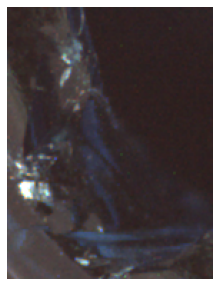

In [27]:
img = cv2.imread("test/defect2_1_ROI.png")
img = cv2.imread(pathname2)
plt.figure(figsize=(5,5)) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## 4.3 Example 3

In [28]:
test_image = "test/defect3.png"

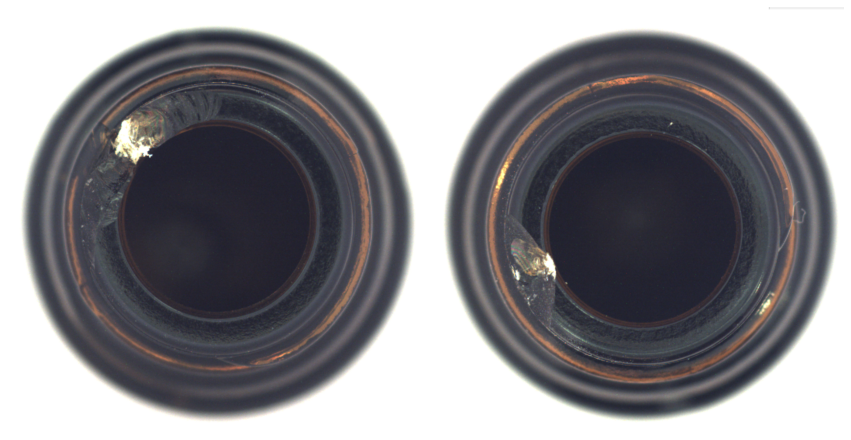

In [29]:
img = cv2.imread(test_image)
plt.figure(figsize=IMAGE_SIZE) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [30]:
t1 = datetime.datetime.now()

data = open(test_image, "rb").read()
headers = {"Content-Type": "application/octet-stream"}
headers["Authorization"] = f"Bearer {key}"
resp = requests.post(scoring_uri, data, headers=headers)

t2 = datetime.datetime.now()
print("Elapsed time:", t2 - t1)

Elapsed time: 0:00:04.250581


In [31]:
RenderJSON(resp.text)

In [32]:
detections = json.loads(resp.text)

nlabel = 1
for detect in detections["boxes"]:
    if detect["score"] > min_confscore: # Min Value
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]
        print("\033[1;31;34m", nlabel, label, 'with confidence =', conf_score)
        print("\nPolygon:", polygon, '\n')
        nlabel+=1

if (nlabel-1) != 0:
    print("\n\033[1;31;91m[Alert]:", nlabel-1, "defect(s) has been detected.")
    
if (nlabel-1) == 0:
    print("\n\033[1;31;34m[OK]: No Quality Control issue has been detected!")

 1 defect with confidence = 0.9840244650840759

Polygon: [[0.10262934690415607, 0.5116666666666667, 0.10008481764206956, 0.5116666666666667, 0.09414758269720101, 0.5033333333333333, 0.090754877014419, 0.49166666666666664, 0.089058524173028, 0.4666666666666667, 0.090754877014419, 0.4583333333333333, 0.090754877014419, 0.37166666666666665, 0.09838846480067855, 0.315, 0.10347752332485156, 0.29833333333333334, 0.11620016963528414, 0.275, 0.1272264631043257, 0.265, 0.13740458015267176, 0.26, 0.15776081424936386, 0.24, 0.1645462256149279, 0.23666666666666666, 0.17896522476675147, 0.22, 0.19592875318066158, 0.21333333333333335, 0.2010178117048346, 0.20833333333333334, 0.21374045801526717, 0.205, 0.23918575063613232, 0.20833333333333334, 0.24342663273960985, 0.22, 0.24342663273960985, 0.24333333333333335, 0.2383375742154368, 0.25166666666666665, 0.23240033927056827, 0.255, 0.22646310432569974, 0.2683333333333333, 0.2171331636980492, 0.27666666666666667, 0.20271416454622562, 0.29833333333333334

Instance Segmentation custom vision model predictions:

 1 	glass Defect(s) detected: defect with confidence = 0.984 	in region: 119.2384 152.4461 243.375 246.5263
 2 	glass Defect(s) detected: defect with confidence = 0.9533 	in region: 875.7737 371.1442 88.4851 195.0689

 >> Total of detected glass defect(s) = 2


<Figure size 1080x864 with 0 Axes>

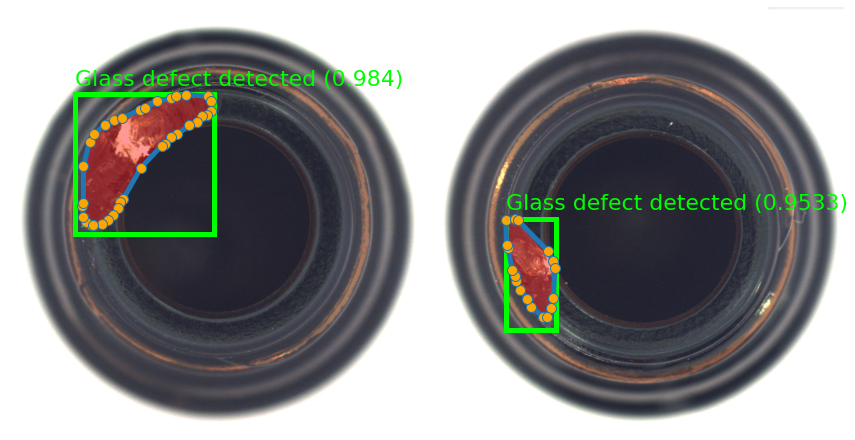

In [33]:
%matplotlib inline
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image

plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(test_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=IMAGE_SIZE) # Dimensions
ax.imshow(img_np)

totalobjects = 0
numberobjects = 1

print("Instance Segmentation custom vision model predictions:\n")

detections = json.loads(resp.text)

for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    polygon = detect["polygon"]
    conf_score = detect["score"]
    
    if conf_score > min_confscore:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        print("\033[1;31;34m", numberobjects, '\tglass Defect(s) detected:', detect["label"], "with confidence =", 
              round(conf_score, round_values),
              "\tin region:", round(topleft_x, round_values), round(topleft_y, round_values), round(width, round_values),
              round(height, round_values))
        
        numberobjects+=1
        
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=rect_line_width,
            edgecolor=color_rect,
            facecolor="none",
        )

        ax.add_patch(rect)
        labeltxt = 'Glass ' + label + ' detected'
        labelmsg = labeltxt + ' (' + str(round(conf_score, round_values)) + ')'
        plt.text(topleft_x, topleft_y - txtoffset, labelmsg, color=color_text, fontsize=font_size)

        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=color_back, alpha=0.4)
        ax.add_patch(poly)
        
        poly_line = Line2D(
            polygon_np[:, 0],
            polygon_np[:, 1],
            linewidth=5,
            marker="o",
            markersize=marker_size,
            markerfacecolor=color_dots,
        )
        ax.add_line(poly_line)
 
    totalobjects = numberobjects - 1
    
    regiontopleftx = int(topleft_x) 
    regiontoplefty = int(topleft_y)
    regionw = int(width)
    regionh = int(height)
    imgtocrop = cv2.imread(test_image)
    cropped_image = imgtocrop[regiontoplefty:regiontoplefty+regionh, regiontopleftx:regiontopleftx+regionw]
    image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    pathname, extension = os.path.splitext(test_image)
    pathname2 = pathname + '_' + str(totalobjects) + '_ROI' + extension
    cv2.imwrite(pathname2,image_rgb)
    


outputfilename = os.path.splitext(test_image)[0] + '_has_' + str(totalobjects) + '_defects.jpg'
fig.savefig(outputfilename, dpi=150) #Saving image

print("\n \033[1;31;91m>> Total of detected glass defect(s) =", totalobjects)
plt.axis('off')
plt.show()

## Extraction of the ROI

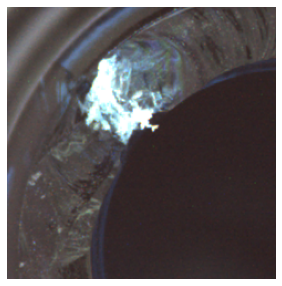

In [34]:
img = cv2.imread("test/defect3_1_ROI.png")
plt.figure(figsize=(5,5)) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

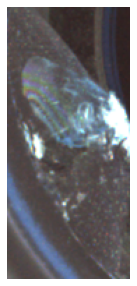

In [35]:
img = cv2.imread("test/defect3_2_ROI.png")
plt.figure(figsize=(5,5)) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## 4.4 Example 4

In [36]:
test_image = "test/ok.png"

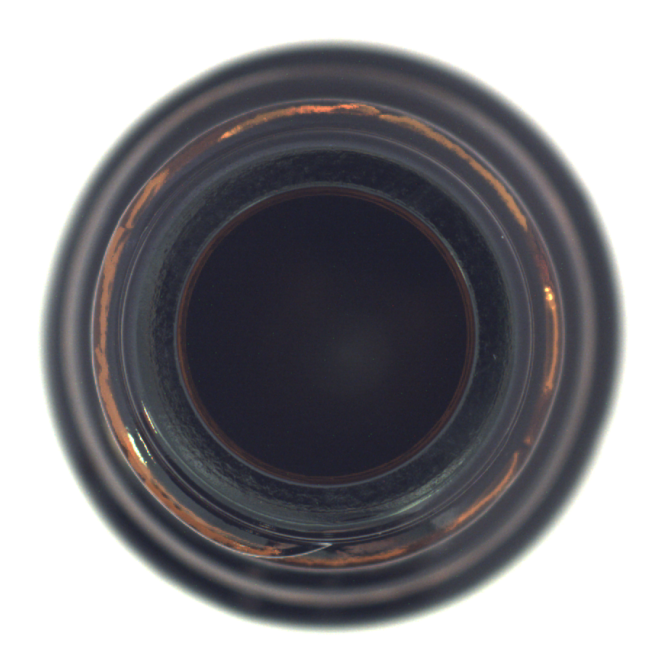

In [37]:
img = cv2.imread(test_image)
plt.figure(figsize=IMAGE_SIZE) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [38]:
t1 = datetime.datetime.now()

data = open(test_image, "rb").read()
headers = {"Content-Type": "application/octet-stream"}
headers["Authorization"] = f"Bearer {key}"
resp = requests.post(scoring_uri, data, headers=headers)

t2 = datetime.datetime.now()
print("Elapsed time:", t2 - t1)

Elapsed time: 0:00:02.236580


In [39]:
RenderJSON(resp.text)

In [40]:
detections = json.loads(resp.text)

nlabel = 1
for detect in detections["boxes"]:
    if detect["score"] > min_confscore: # Min Value
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]
        print("\033[1;31;34m", nlabel, label, 'with confidence =', conf_score)
        print("\nPolygon:", polygon, '\n')
        nlabel+=1

if (nlabel-1) != 0:
    print("\n\033[1;31;91m[Alert]:", nlabel-1, "defect(s) has been detected.")

if (nlabel-1) == 0:
    print("\n\033[1;31;34m[OK]: No Quality Control issue has been detected!")


[OK]: No Quality Control issue has been detected!


Instance Segmentation custom vision model predictions:


 >> Total of detected glass defect(s) = 0


<Figure size 1080x864 with 0 Axes>

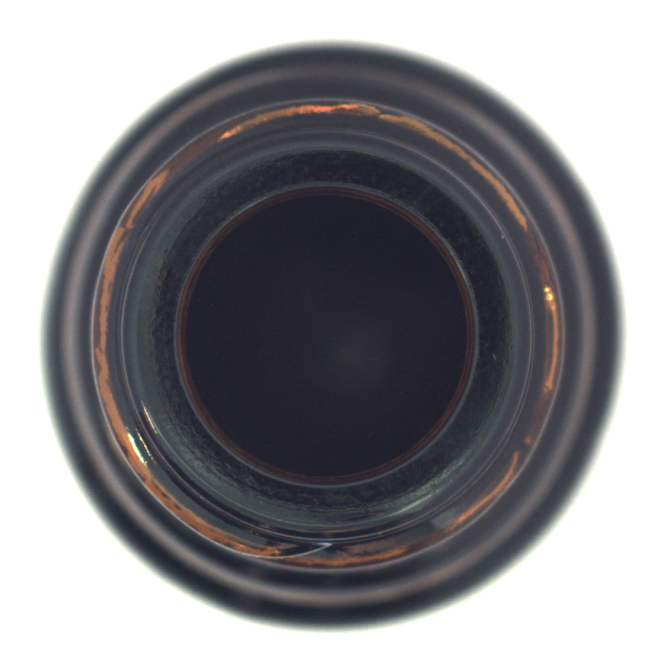

In [41]:
%matplotlib inline
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image

plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(test_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=IMAGE_SIZE) # Dimensions
ax.imshow(img_np)

totalobjects = 0
numberobjects = 1

print("Instance Segmentation custom vision model predictions:\n")

detections = json.loads(resp.text)

for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    polygon = detect["polygon"]
    conf_score = detect["score"]
    
    if conf_score > min_confscore:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        print("\033[1;31;34m", numberobjects, '\tglass Defect(s) detected:', detect["label"], "with confidence =", 
              round(conf_score, round_values),
              "\tin region:", round(topleft_x, round_values), round(topleft_y, round_values), round(width, round_values),
              round(height, round_values))
        
        numberobjects+=1
        
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=rect_line_width,
            edgecolor=color_rect,
            facecolor="none",
        )

        ax.add_patch(rect)
        labeltxt = 'Glass ' + label + ' detected'
        labelmsg = labeltxt + ' (' + str(round(conf_score, round_values)) + ')'
        plt.text(topleft_x, topleft_y - txtoffset, labelmsg, color=color_text, fontsize=font_size)

        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=color_back, alpha=0.4)
        ax.add_patch(poly)
        
        poly_line = Line2D(
            polygon_np[:, 0],
            polygon_np[:, 1],
            linewidth=5,
            marker="o",
            markersize=marker_size,
            markerfacecolor=color_dots,
        )
        ax.add_line(poly_line)
 
    regiontopleftx = int(topleft_x) 
    regiontoplefty = int(topleft_y)
    regionw = int(width)
    regionh = int(height)
    imgtocrop = cv2.imread(test_image)
    cropped_image = imgtocrop[regiontoplefty:regiontoplefty+regionh, regiontopleftx:regiontopleftx+regionw]
    image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    pathname, extension = os.path.splitext(test_image)
    pathname2 = pathname + '_ROI' + extension
    cv2.imwrite(pathname2,image_rgb)
    
    totalobjects = numberobjects - 1

outputfilename = os.path.splitext(test_image)[0] + '_has_' + str(totalobjects) + '_defects.jpg'
fig.savefig(outputfilename, dpi=150) #Saving image

print("\n \033[1;31;91m>> Total of detected glass defect(s) =", totalobjects)
plt.axis('off')
plt.show()